# Annealed Importance Sampling

Simulating samples from distributions, for evaluating downstream quantities such as integrals, is a central problem in Statistics and Machine Learning. For example, we are often interested in evaluating integrals of the form

$$\begin{equation}
I = \int p(x) f(x) dx,
\end{equation}$$

where $p$ is a probability density and $f$ is a function of interest. If we have acccess to the cumulative density function $p$, we can easily draw samples from using [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling). However, it is (most) often the case that the cumulative density function does not have an analytic closed form, so inverse transform sampling does not apply. For example, non-conjugate Bayesian models typically involve intractable distributions of this kind. In such cases, we must resort to Monte Carlo, or other approximate methods.

A standard Monte Carlo method for handling intractable integrals is Importance Sampling. Importance Sampling gets around the intractability of $p$ by introducing another tractable distribution $q$ and drawing samples from $q$ instead. It then corrects for the bias in the samples, to account for the fact that these now come from $q$ rather than $p$, by weighting them appropriately using so called importance weights. Importance Sampling yields an unbiased estimate of downstream integrals, while circumventing the intractability of $p$.

Unfortunately, if $q$ is quite different from $p$, the integral ends up being dominated by a few of the samples which have much larger importance weights than the others. A consequence of this is that the variance of the Importance Sampling estimator can be extremely large, as it is dominated by a few of the samples with large importance weights. Annealed Importance Sampling is a method which circumvents this issue by using an annealing procedure which produces samples with more equally distributed importance weights while remaining unbiased, and can greatly reduce the variance of the resulting estimates.

## Importance Sampling

Suppose we wish to evaluate an integral of the form

$$\begin{equation}
I = \int p(x) f(x) dx.
\end{equation}$$

If we could draw samples from $p$, we could estimate this integral by Monte Carlo

$$\begin{equation}
I \approx \frac{1}{N} \sum_{n=1}^N f(x_n) ~~\text{ where }~~ x_n \sim p.
\end{equation}$$

However, as explained above, most of the time we cannot draw samples from $p$ directly. We can introduce another tractable distribution $q$, and rewrite this integral as 

$$\begin{equation}
I = \int q(x) \frac{p(x)}{q(x)} f(x) dx.
\end{equation}$$

A technical, but important, requirement here is that $q(x)$ should be such that $q$ should be non-zero whenever $p$ is non-zero, for the integral above to be well defined. Hereafter we assume this to be the case. Then, we can estimate the integral as

$$\begin{equation}
I \approx \frac{1}{N} \sum_{n=1}^N \underbrace{\frac{p(x_n)}{q(x_n)}}_{w_n} f(x_n) ~~\text{ where }~~ x_n \sim q.
\end{equation}$$

The ratios $w_n$ are called importance weights, since they weight the contribution of each $f(x_n)$ term in the sum. Since $q$ is used to propose samples used in the Monte Carlo sum, we refer to it as the proposal distribution. We also refer to $p$ as the target distribution, since this is the one we are ultimately interested in. This is called the Imporance Sampling estimator, and is unbiased, meaning that in expectation it is equal to the original integral

$$\begin{equation}
\mathbb{E}\left[ \frac{1}{N} \sum_{n=1}^N \frac{p(x_n)}{q(x_n)} f(x_n) \right] = \frac{1}{N} \sum_{n=1}^N \mathbb{E}\left[\frac{p(x_n)}{q(x_n)} f(x_n) \right] = \frac{1}{N} \sum_{n=1}^N I = I.
\end{equation}$$

In [2]:
from typing import *

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

from IPython.display import HTML, set_matplotlib_formats

tfd = tfp.distributions
dtype = tf.float64

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

Let's look at a simple example of Importance Sampling. Suppose $f(x) = 3^2$ and let $p$ be a mixture of Gaussians

$$\begin{equation}
p(x) = \pi \mathcal{N}(x; \mu_1, \sigma_1^2) + (1 - \pi) \mathcal{N}(x; \mu_2, \sigma_2^2).
\end{equation}$$

Of course, we can in fact draw samples from a mixture of Gaussians directly, however we will pretend we cannot. Now, define $q$ to be a Gaussian

$$\begin{equation}
q(x) = \mathcal{N}(x; \mu_q, \sigma_q^2).
\end{equation}$$

In [3]:
f = lambda x: x**3.

x_plot = tf.cast(tf.linspace(-4., 4., 200), dtype=dtype)

m1 = tf.convert_to_tensor(-2., dtype=dtype)
s1 = tf.convert_to_tensor(0.4, dtype=dtype)

m2 = tf.convert_to_tensor(2., dtype=dtype)
s2 = tf.convert_to_tensor(0.4, dtype=dtype)

mq = tf.convert_to_tensor(0., dtype=dtype)
sq = tf.convert_to_tensor(0.8, dtype=dtype)

mix_probs = tf.convert_to_tensor([0.5, 0.5], dtype=dtype)

p1 = tfd.Normal(loc=m1, scale=s1)
p2 = tfd.Normal(loc=m2, scale=s2)

p = tfd.Mixture(cat=tfd.Categorical(probs=mix_probs), components=[p1, p2])
q = tfd.Normal(loc=mq, scale=sq)

p_plot = tf.math.exp(p.log_prob(x_plot))
q_plot = tf.math.exp(q.log_prob(x_plot))
f_plot = f(x_plot)

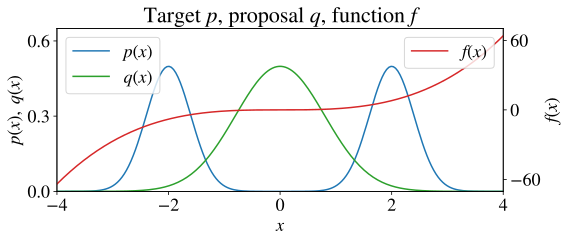

In [4]:
plt.figure(figsize=(8, 3))

plt.plot(
    x_plot,
    p_plot,
    color="tab:blue",
    label="$p(x)$"
)

plt.plot(
    x_plot,
    q_plot,
    color="tab:green",
    label="$q(x)$"
)

plt.title("Target $p$, proposal $q$, function $f$", fontsize=22)
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$p(x),~ q(x)$", fontsize=18)

plt.xticks(tf.linspace(-4., 4., 5), fontsize=18)
plt.yticks(tf.linspace(0., 0.6, 3), fontsize=18)

plt.xlim([-4., 4.])
plt.ylim([0, 0.65])

plt.legend(loc="upper left", fontsize=18)

twin_axis = plt.gca().twinx()

plt.plot(
    x_plot,
    f_plot,
    color="tab:red",
    label="$f(x)$",
)

plt.xlabel("$x$", fontsize=18)
plt.ylabel("$f(x)$", fontsize=18)

plt.legend(loc="upper right", fontsize=18)
plt.yticks(tf.linspace(-60., 60., 3), fontsize=18)

plt.show()

In [5]:
# Set the random seed for repeatable results
tf.random.set_seed(0)

# How many samples to draw
num_samples = 100

# Draw samples
qx = q.sample([num_samples])

# Compute importance weights and importance weighted integral
w = tf.math.exp(p.log_prob(qx) - q.log_prob(qx))
A = tf.reduce_mean(w * f(qx))

print(f"Importance Sampling estimate A = {A:.2f}")

Importance Sampling estimate A = -5.40


Note that because $p(x)$ is symmetric around $x = 0$ and $f(x) = x^3$ is antisymmetric $A$ is zero. However the estimate was $A \approx -5.46$ which seems a bit off. Repeating this experiment $100$ times we obtain:

In [6]:
# How many samples to draw
num_samples = 100
num_trials = 100
    
# Draw samples
qx = q.sample([num_trials, num_samples])

# Compute importance weights and importance weighted integral
w = tf.math.exp(p.log_prob(qx) - q.log_prob(qx))
A = tf.reduce_mean(w * f(qx), axis=1)

mean_A = tf.reduce_mean(A)
std_A = tf.math.reduce_std(A)

print(
    f"Importance Sampling over {num_trials} trials "
    f"A = {mean_A:.2f} +/- {2.*std_A:.3f}."
)

Importance Sampling over 100 trials A = 0.10 +/- 13.309.


So even though the estimator is unbiased, it has a large variance. Compare this to a Monte Carlo estimate using samples directly from $p$. This should give us an idea of how much random error we should expect if we had access to exact samples from $p$.

In [7]:
# How many samples to draw
num_samples = 100
num_trials = 100
    
# Draw samples
px = q.sample([num_trials, num_samples])

# Compute importance weights and importance weighted integral
A = tf.reduce_mean(w * f(px), axis=1)

mean_A = tf.reduce_mean(A)
std_A = tf.math.reduce_std(A)

print(
    f"Monte Carlo with samples from p over {num_trials} trials "
    f"A = {mean_A:.2f} +/- {2.*std_A:.3f}."
)

Monte Carlo with samples from p over 100 trials A = -0.07 +/- 1.848.


The Importance sampling estimator has seven times larger random error than the Monte Carlo estimator! To see why, this occurs, let's plot the raw samples drawn from $q$ (in green) as well as the samples weighted according to their importance weights (in blue).

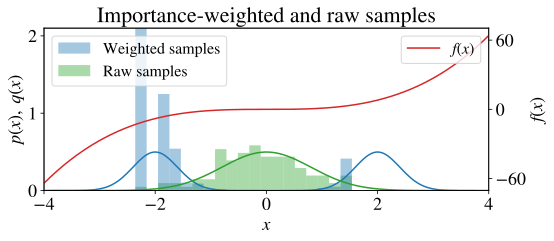

In [11]:
# Set the random seed for repeatable results
tf.random.set_seed(0)

# How many samples to draw
num_samples = 100

# Draw samples and compute importance weights
qx = q.sample([num_samples])
w = tf.math.exp(p.log_prob(qx) - q.log_prob(qx))

# Plot distributions and samples
plt.figure(figsize=(8, 3))

plt.plot(
    x_plot,
    p_plot,
    color="tab:blue",
)

plt.plot(
    x_plot,
    q_plot,
    color="tab:green",
)

# Plot samples weighted by their importance weights
plt.hist(
    qx,
    weights=w,
    density=True,
    color="tab:blue",
    alpha=0.4,
    bins=tf.linspace(-4., 4., 40),
    zorder=2,
    label="Weighted samples"
)

# Plot raw samples
plt.hist(
    qx,
    density=True,
    color="tab:green",
    alpha=0.4,
    bins=tf.linspace(-4., 4., 40),
    zorder=1,
    label="Raw samples"
)

plt.title("Importance-weighted and raw samples", fontsize=22)
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$p(x),~ q(x)$", fontsize=18)
plt.xticks(tf.linspace(-4., 4., 5), fontsize=18)
plt.yticks(tf.linspace(0., 2.0, 3), fontsize=18)

plt.xlim([-4., 4.])
plt.ylim([0, 2.1])

plt.legend(loc="upper left", fontsize=16)

twin_axis = plt.gca().twinx()

plt.plot(
    x_plot,
    f_plot,
    color="tab:red",
    label="$f(x)$",
)

plt.ylabel("$f(x)$", fontsize=18)

plt.legend(loc="upper right", fontsize=16)
plt.yticks(tf.linspace(-60., 60., 3), fontsize=18)

plt.show()

First off, this plot illustrates how Importance Sampling works. Although the proposal $q$ proposes many samples in the middle, these are down-weighted by the importance weights, since the target $p$ has small density there. Conversely, whenever $q$ proposes a sample at a point where $p$ has high density, the importance weight becomes much larger. In this way, Importance Sampling moulds the empirical distribution of samples from $q$ (in green) to resemble the target distribution $p$ (in blue).

However, the events where $q$ proposes a high-importance sample occcurs relatively infrequently, which means that sometimes we may get sample with a large importance weight in one of the two Gaussian modes, but not in the other mode. Since this sample has a large importance weight, it greatly affects the overall estimate, introducing lots of random error. Looking at a histogram of the importance weights we see that most weights are very small, and it's only a few large weights which dominate the value of the integral - note the $x$-axis has a log-scale.

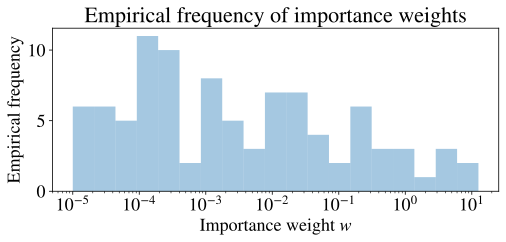

In [12]:
# Plot distributions and samples
plt.figure(figsize=(8, 3))

# Plot importance weights
plt.hist(
    w,
    density=False,
    color="tab:blue",
    alpha=0.4,
    bins=10**tf.linspace(-5., 1.1, 20),
    zorder=2,
    label="Importance weights",
)

plt.title("Empirical frequency of importance weights", fontsize=22)

plt.xlabel("Importance weight $w$", fontsize=18)
plt.ylabel("Empirical frequency", fontsize=18)

plt.xticks(fontsize=18)
plt.yticks([0, 5, 10], fontsize=18)

plt.xscale("log")

plt.show()

Going a little further, note that the expectation of the value of an importance weight is always equal to one since

$$\begin{equation}
\int q(x) \frac{p(x)}{q(x)} dx = 1 \implies \mathbb{E}_{x \sim q(x)}\left[\frac{p(x)}{q(x)} \right] = 1,
\end{equation}$$

This means that if $q$ proposes samples with small importance weights most of the time, it must also propose some samples with very large importance weights to make up for the small importance weights. The quantity which affects the amount of random error in an importance sampling estimator is the variability of the importance weights around this mean, that is the variance of the importance weights. It is reasonable to expect that the more dissimilar $q$ and $p$ are, the larger the variance will be. In partricular, we can show that the variance of the importance weights can be lower bounded by a quantity that scales exponentially with the KL divergence.

<div class="lemma">
    
**Lemma (Lower bound to importance weight variance)** Given distributions $p$ and $q$, it holds that
    
$$\begin{equation}
\text{Var}_{x \sim q}\left[\frac{p(x)}{q(x)}\right] \geq e^{D_{KL}(p || q)} - 1,
\end{equation}$$
    
where $D_{KL}(p || q)$ is the Kullback-Leibler diverence from $p$ to $q$, measured in nats.
    
</div>
<br>


<details class="proof">
<summary>Derivation: Lower bound to importance weight variance</summary>
<br>
    
The variance in the importance weights can be written as

$$\begin{align}
\text{Var}_{x \sim q}\left[\frac{p(x)}{q(x)}\right] &= \mathbb{E}_{x \sim q}\left[\left(\frac{p(x)}{q(x)}\right)^2\right] - \mathbb{E}_{x \sim q}\left[\frac{p(x)}{q(x)}\right]^2, \\
&= \mathbb{E}_{x \sim q}\left[\left(\frac{p(x)}{q(x)}\right)^2\right] - 1, \\
&= \mathbb{E}_{x \sim p}\left[\frac{p(x)}{q(x)}\right] - 1, \\
\end{align}$$

By applying Jensen's inequality once, we can get a lower bound to the expectation above, to obtain

$$\begin{align}
\text{Var}_{x \sim q}\left[\frac{p(x)}{q(x)}\right] &= \exp\left(\log\left( \mathbb{E}_{x \sim p}\left[\frac{p(x)}{q(x)}\right] \right)\right) - 1 \\
&\geq \exp\left(\mathbb{E}_{x \sim p}\left[\log\left(\frac{p(x)}{q(x)} \right)\right]\right) - 1 \\
&= e^{D_{KL}(p || q)} - 1,
\end{align}$$

which is the lower bound in the lemma.
    
</details>
<br>

Note that when $q = p$, this lower bound becomes $0$. This is in agreement with the fact that when $q = p$, all importance weights are equal to $1$, and the variance in the importance weights is $0$. As $q$ becomes more and more dissimilar to $p$, $D_{KL}(q || p)$ increases and so does the lower bound. Therefore the variance also increases and in fact it increases at least exponentially with $D_{KL}(q || p)$. Of course, this is only a lower bound, and the actual variance can be significantly larger than this. On the flipside, this lower bound tells us that if we want to reduce the variance in the importance weights we must draw our samples from a proposal distribution which matches the target distribution as closely as possible.

This is where Annealed Importance Sampling (AIS) becomes useful. AIS is an importance sampling method which uses an annealing procedure based on Markov Chain Monte Carlo (MCMC), aimed at producing samples whose distribution is closer to $p$. To achieve this, instead of using samples from $q$ directly in the importance weighted estimator, AIS gradually transforms the samples, such that their distribution is closer to $p$. This reduces the variability in the importance samples and thus the random error in the importance sampling estimator.

## Annealed Importance Sampling

AIS has two salient parts to it, namely Markov Chain Monte Carlo (MCMC) and distribution annealing, motivated by the following intuition. Given some initial samples from $q$, we want to transform them in a way such that the distribution of the transformed samples is as close to $p$ as possible, because this would reduce the variance of the importance weights and thus the error in our estimator. Markov Chain Monte Carlo (MCMC) is a standard class of methods geared towards solving this type of problem: an MCMC algorithm begins from an arbitrarily initialised point, and proceeds to transform this point in a randomised way, such that the distribution of the transformed point is close to a target distribution. So we could, in principle, use MCMC within an importance-weighted estimator to reduce its variance. The following algorithm is based on this intuition.

<div class="definition">
    
**Algorithm (An importance weighted MCMC algorithm)** Given a proposal density $q$, a target density $p$ and a sequence of transition kernels $T_1(x, x'), \dots, T_K(x, x')$ be a sequence of transition kernels such that $T_k$ leaves $p$ invariant. Sampling $x_0 \sim q(x)$ followed by
    
$$\begin{equation}
x_k \sim T_k(x_{k-1}, x_k) ~\text{ for }~ k = 1, \dots, K,
\end{equation}$$
    
and return the sample $x_K$ with an appropriately chosen importance weight $w$ such that the resulting estimator is unbiased.
    
</div>
<br>

Note that the only requirement on the transition kernels $T_k(x, x')$ is that they leave $p$ invariant, and do not need to result in an ergodic Markov Chain, which is a usual requirement in standard MCMC. The distribution which results after drawing an intial sample drawn from the proposal $q$ and applying the transition kernels $T_1(x, x'), \dots, T_K(x, x')$ can be written as

$$\begin{align}
q_K(x_K) = \int q(x_0) T_1(x_0, x_1) \dots T_K(x_{K-1}, x_K) dx_0 \dots dx_{K-1},
\end{align}$$

and this gets closer and closer to $p$ as we increase $K$. Note that this algorithm does not specify how to select $w$. However, while we could in principle draw $x_K \sim q_K$ and return this sample together with the importance weight

$$\begin{align}
w = \frac{p(x_K)}{q_K(x_K)},
\end{align}$$

each of the nested integrals above is intractable, which means we cannot compute $q_K$ in closed form, and by extension we cannot compute $w$ in closed form either. One way to get around this issue, is to consider the joint distribution of $(x_0, x_1, \dots, x_K)$ under the Markov Chain, which has density

$$\begin{align}
h(x_0, x_1, \dots, x_K) = q(x_0) T_1(x_0, x_1) \dots T_K(x_{K-1}, x_K).
\end{align}$$

We can then define the reverse transition kernels $\tilde{T}_k$ as

$$\begin{align}
\tilde{T}_k(x, x') = T_k(x', x)\frac{p(x')}{p(x)}.
\end{align}$$

Because $T_k$ leaves $p$ invariant, it holds that

$$\begin{align}
\tilde{T}_k(x, x') = \int T_k(x', x)\frac{p(x')}{p(x)} dx' = \frac{1}{p(x)}\int T_k(x', x)p(x') dx' = 1,
\end{align}$$

so the reverse kernels are guaranteed to be valid transition kernels. We can now consider a reversed Markov chain which starts with the target distribution $p$ as its intial distribution and applies the reverse kernels $\tilde{T}_k$. This Markov chain has corresponding joint distribution

$$\begin{align}
\tilde{h}(x_0, x_1, \dots, x_K) = p(x_K) \tilde{T}_K(x_K, x_{K-1}) \dots \tilde{T}_1(x_1, x_0).
\end{align}$$

Now, consider performiing importance sampling in this augmented space, with $h$ as the proposal and $\tilde{h}$ as the target distributions. Specifically, we draw draw $(x_{n, 0}, \dots, x_{n, K}) \sim h$ for $n = 1, \dots, N$ and compute the importance weight

$$\begin{align}
w_n = \frac{\tilde{h}(x_{n, 0}, \dots, x_{n, K})}{h(x_{n, 0}, \dots, x_{n, K})}.
\end{align}$$

The importance weights $w_n$ ensure that if $g$ is an arbitrary function of the augmented sample, the importance weighted estimator

$$\begin{align}
\int g(x_0, \dots, x_K) \tilde{h}(x_0, \dots, x_K) dx_0 \dots dx_K \approx \frac{1}{N}\sum_{n=1}^N w_n g(x_{n, 0}, \dots, x_{n, K}),
\end{align}$$

is unbiased. Therefore, if we set $g(x_{n, 1}, \dots, x_{n, K}) = f(x_{n, K})$, we obtain the estimator

$$\begin{align}
\int f(x_K) p(x_K) dx_K = \int g(x_0, \dots, x_K) \tilde{h}(x_0, \dots, x_K) dx_0 \dots dx_K \approx \frac{1}{N}\sum_{n=1}^N w_n g(x_{n, 0}, \dots, x_{n, K}),
\end{align}$$

which is also unbiased. Crucially, the importance weights $w_n$ can actually be computed in closed form because all the terms from the transition kernels in the importance weight ratio cancel, yielding

$$\begin{align}
w_n = \frac{\tilde{h}(x_{n, 0}, \dots, x_{n, K})}{h(x_{n, 0}, \dots, x_{n, K})} = \frac{p(x_0)}{q(x_0)}.
\end{align}$$

By virtue of $T_k$ leaving $p$ invariant, we can compute the importance weight in closed form. Note also that this algorithm description leaves $w$ unspecified. By virtue of $T_k$ leaving $p$ invariant, we can compute the importance weight in closed form.

<div class="lemma">
    
**Lemma (Weights of importance weighted MCMC)** Given a proposal density $q$, a target density $p$ and a sequence $(x_0, x_1, \dots, x_N)$, the importance weight $w$ which makes the above estimator unbiased is
    
$$\begin{equation}
w = \frac{p(x_0)}{q(x_0)}.
\end{equation}$$
    
</div>
<br>


<details class="proof">
<summary>Proof: Weights of importance weighted MCMC</summary>
    
Suppose $p$ and $q$ are a target and proposal densities respectively and $T_1(x, x'), \dots, T_K(x, x')$ is a sequence of transition kernels such that $T_k$ leaves $p$ invariant. Then, define the probability density $h$ as
    
$$\begin{equation}
h(x_0, x_1, \dots, x_K) \sim q(x_0) T_1(x_0, x_1) \dots T_K(x_{K-1}, x_K).
\end{equation}$$
    
Now, define $\tilde{T}_1(x, x'), \dots, \tilde{T}_K(x, x')$ as
    
$$\begin{equation}
\tilde{T}_n(x, x') = T_n(x', x) \frac{p(x')}{p(x)}.
\end{equation}$$
    
Because each $T_k$ leaves $p$ invariant, we have
    
$$\begin{equation}
\int \tilde{T}_k(x, x') dx' = \int T_k(x', x) \frac{p(x')}{p(x)} dx' = \frac{1}{p(x)} \int T_k(x', x) p(x') dx' = 1,
\end{equation}$$
    
so $\tilde{T}_1, \dots, \tilde{T}_K$ are valid transition kernels. Noting this, we can also define the density $\tilde{f}$ as
    
$$\begin{equation}
\tilde{h}(x_0, x_1, \dots, x_K) \sim p(x_K) \tilde{T}_N(x_K, x_{K-1}) \dots \tilde{T}_1(x_1, x_0).
\end{equation}$$
    
Now, we can consider an augmented importance sampling scheme, where we draw a sample from the joint distribution with density $h$, and then compute the importance weight
    
$$\begin{align}
w &= \frac{\tilde{h}(x_0, x_1, \dots, x_K)}{h(x_0, x_1, \dots, x_K)} \\
  &= \frac{p(x_0)}{q(x_0)} \frac{p(x_1)}{p(x_1)} \dots \frac{p(x_N)}{p(x_N)} \\
  &= \frac{p(x_0)}{q(x_0)}.
\end{align}$$
    
Now, repeating this sampling procedure $N$ times we obtain the augmented samples $(x_{n, 0}, x_{n, 1}, \dots, x_{n, K})$ with corresponding importance weights $w_n$ for $n = 1, \dots, K$. For any function $g$, the average
    
$$\begin{equation}
\frac{1}{N} \sum_{n=1} w_n g(x_{n, 0}, x_{n, 1}, \dots, x_{n, K})
\end{equation}$$
    
is an unbiased estmate of the integral
    
$$\begin{equation}
\int \tilde{h}(x_0, x_1, \dots, x_K) g(x_0, x_1, \dots, x_K) dx_0 dx_1 \dots dx_K.
\end{equation}$$
    
Now, lettng the function $g$ be
    
$$\begin{equation}
g(x_0, x_1, \dots, x_K) = f(x_K),
\end{equation}$$
    
we see that the average
    
$$\begin{equation}
\frac{1}{N} \sum_{n=1} w_n f(x_{n, K})
\end{equation}$$
    
is an unbiased estimate of $\int p(x) f(x) dx$.

    
</details>
<br>

Unfortunately, this importance weight is exactly the same weight as that given by standard importance sampling. So this algorithm does not improve on the variance of the importance weighs. To get around this issue, instead of using transition kernels $T_k$ which leave $p$ invariant, AIS introduces a sequence of annealed distributions with densities
    
$$\begin{equation}
\pi_k(x) = p(x)^{\beta_k} q(x)^{(1 - \beta_k)}
\end{equation}$$

for a given sequence $0 = \beta_0 \leq \dots \leq \beta_K = 1$, and instead requires that $T_k$ leaves $\pi_k$ invariant, to obtain the following algorithm.

<div class="definition">
    
**Definition (Annealed Importance Sampling)** Given a proposal density $p$, a target density $q$ and a sequence $0 = \beta_0 \leq \dots \leq \beta_K = 1$, define
    
$$\begin{equation}
\pi_k(x) = p(x)^{\beta_n} q(x)^{(1 - \beta_k)}
\end{equation}$$
    
and let $T_1(x, x'), \dots, T_K(x, x')$ be a sequence of transition kernels such that $T_k$ leaves $\pi_k$ invariant. Annealed Impoprtance Sampling amounts to drawing $x_0 \sim \pi_0(x)$ followed by
    
$$\begin{equation}
x_k \sim T_k(x_{k-1}, x_k) ~\text{ for }~ k = 1, \dots, K,
\end{equation}$$
    
and return the sample $x_K$ with an appropriately chosen importance weight $w$ such that the resulting estimator is unbiased.
    
</div>
<br>

Again, we can compute the importance weight of AIS in closed form, as shown below.

<div class="lemma">
    
**Lemma (Annealed Importance Sampling weights)** Given a proposal density $q$, a target density $p$ and a sequence $(x_0, x_1, \dots, x_N)$, the importance weight $w$ which makes the AIS estimator unbiased is
    
$$\begin{equation}
w = \frac{\pi_1(x_1)}{\pi_0(x_1)} \dots \frac{\pi_N(x_N)}{\pi_{N-1}(x_N)}.
\end{equation}$$
    
</div>
<br>

In [15]:
class TransitionKernel:
    
    def __init__(self):
        pass
        
    def __call__(self, x: tf.Tensor):
        pass

    
class GaussianTransitionKernel(TransitionKernel):
    
    def __init__(self, scale: tf.Tensor):
        
        self.scale = scale
        
    def __call__(self, x: tf.Tensor, distribution: tf.Tensor):
        
        # Create forward proposal distribution and propose next point
        forward = tfd.Normal(loc=x, scale=self.scale)
        next_x = forward.sample()
        
        # Create reverse proposal distribution
        reverse = tfd.Normal(loc=next_x, scale=self.scale)
        
        # Compute acceptance probability
        log_prob_1 = forward.log_prob(next_x) + distribution(next_x)
        log_prob_2 = reverse.log_prob(x) + distribution(x)
        
        log_prob_ratio = log_prob_1 - log_prob_2
        p = tf.math.exp(tf.reduce_min([0., log_prob_ratio]))
        
        # Accept reject step
        accept = tf.random.categorical(
            [[tf.math.log(1. - p), tf.math.log(p)]],
            num_samples=1,
            dtype=tf.int32
        )[0, 0]
        
        x_accept = tf.convert_to_tensor([x, next_x])[accept]
        
        return x_accept, accept

In [29]:
class AnnealedImportanceSampler:
    
    def __init__(
            self,
            initial_distribution: tfd.Distribution,
            target_distribution: tfd.Distribution,
            transition_kernel: TransitionKernel,
            betas: List[float],
        ):
        
        self.initial_distribution = initial_distribution
        self.target_distribution = target_distribution
        self.transition_kernel = transition_kernel
        
        self.betas = betas
        self.num_steps = betas.shape[0]

    @tf.function(jit_compile=True)
    def run_chain(self, x: tf.Tensor, *args):
        
        # Initialise chain history and current distribution
        chain_history = [x]
        annealed_log_prob = self.initial_distribution.log_prob
        
        # Initialise log importance weight
        log_w = - annealed_log_prob(x)
        
        for i in tf.range(self.num_steps):
            
            # Create next annealed distribution
            next_annealed_log_prob = self.log_geometric_mixture(beta=betas[i])
            log_w = log_w + next_annealed_log_prob(x)
            
            # Propose next point
            x, accept = self.transition_kernel(
                x=x,
                distribution=next_annealed_log_prob,
            )
            
            log_w = log_w - next_annealed_log_prob(x)
            
            annealed_log_prob = next_annealed_log_prob
            chain_history.append(x)
            
        log_w = log_w + self.target_distribution.log_prob(x)
        
        return tf.convert_to_tensor([x, log_w], dtype=tf.float64)
            
            
    def log_geometric_mixture(self, beta: tf.Tensor):
        
        def _log_geometric_mixture(x: tf.Tensor):
            
            log_prob_1 = self.initial_distribution.log_prob(x)
            log_prob_2 = self.target_distribution.log_prob(x)
            
            return ((1. - beta) * log_prob_1 + beta * log_prob_2)
        
        return _log_geometric_mixture

In [30]:
dtype = tf.float64

transition_scale = tf.convert_to_tensor(0.3, dtype=dtype)

m1 = tf.convert_to_tensor(-2., dtype=dtype)
s1 = tf.convert_to_tensor(0.4, dtype=dtype)

m2 = tf.convert_to_tensor(2., dtype=dtype)
s2 = tf.convert_to_tensor(0.4, dtype=dtype)

mq = tf.convert_to_tensor(0., dtype=dtype)
sq = tf.convert_to_tensor(0.8, dtype=dtype)

mix_probs = tf.convert_to_tensor([0.5, 0.5], dtype=dtype)

p1 = tfd.Normal(loc=m1, scale=s1)
p2 = tfd.Normal(loc=m2, scale=s2)

p = tfd.Mixture(cat=tfd.Categorical(probs=mix_probs), components=[p1, p2])
q = tfd.Normal(loc=mq, scale=sq)

transition_kernel = GaussianTransitionKernel(
    scale=transition_scale
)

In [31]:
betas = tf.nn.sigmoid(10. * (tf.cast(tf.linspace(1e-3, 1., 1000), dtype=dtype) - 0.5))

sampler = AnnealedImportanceSampler(
    initial_distribution=q,
    target_distribution=p,
    transition_kernel=transition_kernel,
    betas=betas,
)

sampler.run_chain(tf.convert_to_tensor(0., dtype=dtype))

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 2.02364964, -0.46878056])>

In [32]:
x0 = q.sample([100])

result = tf.map_fn(sampler.run_chain, x0)
samples = result[:, 0]
log_weights = result[:, 1]

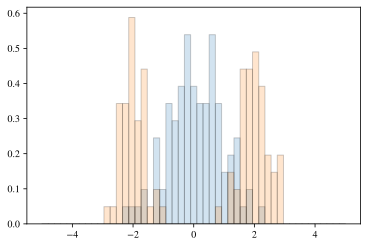

In [33]:
plt.hist(x0, bins=tf.linspace(-5., 5., 50), density=True, alpha=0.2, edgecolor="black", linewidth=1.)
plt.hist(samples, bins=tf.linspace(-5., 5., 50), density=True, alpha=0.2, edgecolor="black", linewidth=1.)
plt.show()

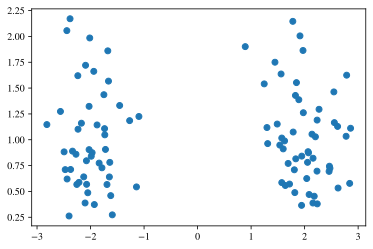

In [34]:
plt.scatter(samples, tf.math.exp(log_weights))
plt.show()

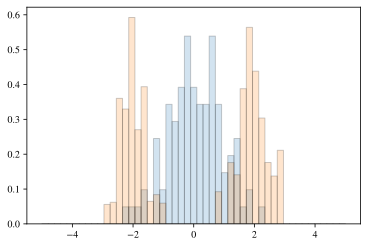

In [35]:
plt.hist(x0, bins=tf.linspace(-5., 5., 50), density=True, alpha=0.2, edgecolor="black", linewidth=1.)
plt.hist(
    samples,
    bins=tf.linspace(-5., 5., 50),
    density=True, alpha=0.2,
    edgecolor="black",
    linewidth=1.,
    weights=tf.math.exp(log_weights)
)

plt.show()

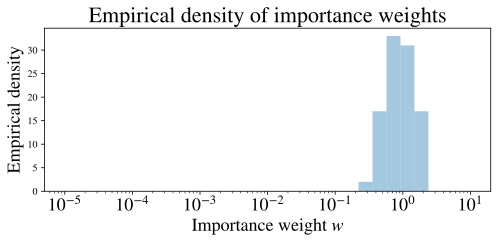

In [36]:
# Plot distributions and samples
plt.figure(figsize=(8, 3))

# Plot importance weights
plt.hist(
    tf.math.exp(result[:, 1]),
    density=False,
    color="tab:blue",
    alpha=0.4,
    bins=10**tf.linspace(-5., 1.0, 30),
    zorder=2,
    label="Importance weights",
)

plt.title("Empirical density of importance weights", fontsize=22)

plt.xlabel("Importance weight $w$", fontsize=18)
plt.ylabel("Empirical density", fontsize=18)

plt.xticks(fontsize=18)
# plt.yticks([0, 3, 6], fontsize=18)

plt.xscale("log")
# plt.yscale("log")

plt.show()

In [37]:
num_trials = 100

estimates = []

for i in range(num_trials):
    
    x0 = q.sample([100])

    result = tf.map_fn(sampler.run_chain, x0)
    samples = result[:, 0]
    log_weights = result[:, 1]

    estimates.append(tf.reduce_mean(tf.math.exp(result[:, 1]) * f(result[:, 0])))
    
tf.reduce_mean(estimates), 2. * tf.math.reduce_std(estimates)

(<tf.Tensor: shape=(), dtype=float64, numpy=0.21540655061548253>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.2341145928930457>)